# Exploring Learned Representations with XOR

This notebook explores how neural networks learn internal representations through various experiments and visualizations.

## Setup

### Get all the necessary files

In [1]:
import os

if os.path.exists("CVIMR"):
    print("You already have all the components to run this notebook. Please run the test setup script anyway to ensure that the setup is correct!")
else:
    !git clone https://github.com/lorenzo-27/CVIMR.git
    print("CVIMR repository cloned successfully. Please run the test setup script anyway to ensure that the setup is correct!")

Cloning into 'CVIMR'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 37), reused 54 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 3.42 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (37/37), done.
CVIMR repository cloned successfully. Please run the test setup script anyway to ensure that the setup is correct!


### Install the package
Install the **CVIMR** package, using the appropriate path for Colab or Local environments.

In [2]:
if os.path.exists("../content"): # Colab
  !pip install -e CVIMR/
else: # Local
  !pip install -e .

Obtaining file:///content/CVIMR
  Preparing metadata (setup.py) ... done
  Running setup.py develop for CVIMR


### Test setup and verify all components work correctly.

In [4]:
if os.path.exists("../content"): # Colab
  !python3 CVIMR/CVIMR/test_setup.py
else: # Local
  !python3 CVIMR/test_setup.py

╭──────────────────────────────────────────╮
│ XOR Representation Learning - Setup Test │
│ Testing all components...                │
╰──────────────────────────────────────────╯

Testing imports...
┌──────────────┬───┐
│ PyTorch      │ ✓ │
│ NumPy        │ ✓ │
│ Matplotlib   │ ✓ │
│ Scikit-learn │ ✓ │
│ Rich         │ ✓ │
└──────────────┴───┘

Testing custom modules...
✓ All custom modules imported successfully

Testing device detection...
┌───────────────────┬──────────┐
│ Device            │ cuda     │
│ CUDA available    │ True     │
│ MPS available     │ False    │
│ CUDA device count │ 1        │
│ CUDA device name  │ Tesla T4 │
└───────────────────┴──────────┘

Testing model creation...
✓ RELU: 9 parameters
✓ TANH: 9 parameters
✓ SIGMOID: 9 parameters
✓ Identity initialization works

Testing data generation...
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Dataset   ┃ Shape                ┃ Labels ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ XOR       │ torch.Size([4, 2])

### Imports & setup

In [5]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from rich.console import Console

# Import custom modules
if os.path.exists("../../content"): # Colab
  from CVIMR.CVIMR.model import TwoLayerNet, get_device
  from CVIMR.CVIMR.data import (generate_xor, generate_3input_xor,
                          generate_two_moons, generate_spiral, generate_circles)
  from CVIMR.CVIMR.training import train_model, compute_accuracy
  from CVIMR.CVIMR.visualization import (plot_weight_trajectories,
                                  plot_activation_histograms, plot_3d_latent_pca,
                                  create_latent_animation)
else: # Local
  from CVIMR.model import TwoLayerNet, get_device
  from CVIMR.data import (generate_xor, generate_3input_xor,
                          generate_two_moons, generate_spiral, generate_circles)
  from CVIMR.training import train_model, compute_accuracy
  from CVIMR.visualization import (plot_weight_trajectories,
                                  plot_activation_histograms, plot_3d_latent_pca,
                                  create_latent_animation)

console = Console()

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Get device
device = get_device()
console.print(f"[bold green]Using device: {device}[/bold green]")

Using device: cuda

## Experiment 1: Classic XOR with Different Activation Functions

We train three models with different activation functions (ReLU, Tanh, Sigmoid)
and compare their learned representations.

In [6]:
# Generate XOR data
x_data, y_data = generate_xor()
console.print(f"[bold]XOR Dataset:[/bold]")
console.print(f"X: {x_data}")
console.print(f"Y: {y_data}")

XOR Dataset:

X: tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

Y: tensor([[0.],
        [1.],
        [1.],
        [0.]])

We have the necessity of the TwoLayerNet class. Minsky and Papert  proved that single-layer perceptrons could not learn the XOR function (non-linearly separable data) - [Minsky, M., & Papert, S. (1969). Perceptrons: An Introduction to Computational Geometry. MIT Press](https://direct.mit.edu/books/monograph/3132/PerceptronsAn-Introduction-to-Computational).

We use gradient descent to train the model (`train_model` function) and visualize the hidden states (`get_latent_tensor`). The algorithm that allows the hidden layer to learn these internal representations is Backpropagation, introduced by [Rumelhart et al., 1986](https://www.nature.com/articles/323533a0).

In [19]:
# Train models with different activations
activations = ['relu', 'tanh', 'sigmoid']
histories = {}
models = {}

for activation in activations:
    console.print(f"\n[bold cyan]Training with {activation.upper()} activation[/bold cyan]")

    # Create and initialize model
    model = TwoLayerNet(input_dim=2, hidden_dim=2, output_dim=1, activation=activation)
    try:
        model.initialize_identity()
    except:
        pass  # Skip if not 2x2

    # Train model
    history = train_model(
        model=model,
        x_data=x_data,
        y_data=y_data,
        lr=3,
        max_epochs=10000,
        threshold=1e-5,
        device=device,
        record_interval=10,
        use_bce=False
    )

    histories[activation] = history
    models[activation] = model

    # Test accuracy
    accuracy = compute_accuracy(model, x_data, y_data, device=device)
    console.print(f"[bold green]Final Accuracy: {accuracy:.4f}[/bold green]")

Training with RELU activation

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.270304, Accuracy 0.7500

Epoch 1000: Loss 0.000154, Accuracy 1.0000

Epoch 2000: Loss 0.000072, Accuracy 1.0000

Epoch 3000: Loss 0.000047, Accuracy 1.0000

Epoch 4000: Loss 0.000034, Accuracy 1.0000

Epoch 5000: Loss 0.000027, Accuracy 1.0000

Epoch 6000: Loss 0.000022, Accuracy 1.0000

Epoch 7000: Loss 0.000019, Accuracy 1.0000

Epoch 8000: Loss 0.000017, Accuracy 1.0000

Epoch 9000: Loss 0.000015, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000013

Eval predictions: tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')


Final Accuracy: 1.0000

Training with TANH activation

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.266665, Accuracy 0.5000

Epoch 1000: Loss 0.000298, Accuracy 1.0000

Epoch 2000: Loss 0.000141, Accuracy 1.0000

Epoch 3000: Loss 0.000092, Accuracy 1.0000

Epoch 4000: Loss 0.000068, Accuracy 1.0000

Epoch 5000: Loss 0.000054, Accuracy 1.0000

Epoch 6000: Loss 0.000045, Accuracy 1.0000

Epoch 7000: Loss 0.000038, Accuracy 1.0000

Epoch 8000: Loss 0.000033, Accuracy 1.0000

Epoch 9000: Loss 0.000030, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000027

Eval predictions: tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')


Final Accuracy: 1.0000

Training with SIGMOID activation

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.316181, Accuracy 0.5000

Epoch 1000: Loss 0.002630, Accuracy 1.0000

Epoch 2000: Loss 0.001005, Accuracy 1.0000

Epoch 3000: Loss 0.000612, Accuracy 1.0000

Epoch 4000: Loss 0.000438, Accuracy 1.0000

Epoch 5000: Loss 0.000340, Accuracy 1.0000

Epoch 6000: Loss 0.000278, Accuracy 1.0000

Epoch 7000: Loss 0.000235, Accuracy 1.0000

Epoch 8000: Loss 0.000203, Accuracy 1.0000

Epoch 9000: Loss 0.000179, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000160

Eval predictions: tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')


Final Accuracy: 1.0000

### Visualization: Latent Space Trajectories

The following code cell plots the **latent space trajectories** of samples during model training, comparing different activation functions. The latent space represents a compact projection of the learned features, where each point corresponds to the model’s internal state for a given sample. These trajectories illustrate how the representations evolve across epochs (recorded every 10 epochs - `record_interval=10`), showing how the model gradually separates the data. Each curve starts at the initial point (square) and ends at the final point (circle) in the 2D latent space.

The following snippet creates three `.mp4` animations of the latent space evolution. It takes ~60s to execute, if you want to save some time you can obviously comment these lines of code:

```
# Create animation of latent space evolution
    anim = create_latent_animation(
        latent_history=latent_history,
        y_data=y_data,
        filename=f"latent_evolution_{activation}.mp4",
        interval=1000,
        title="Latent Space Evolution During Training"
    )

```

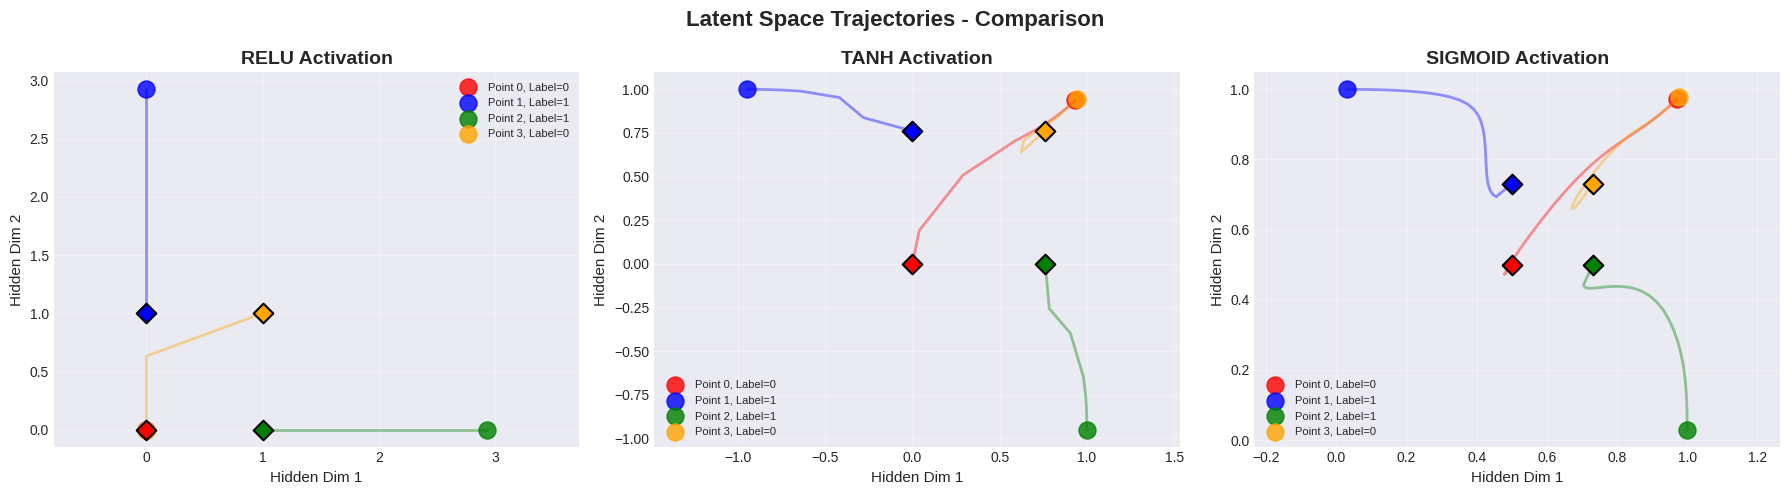

In [20]:
# Plot latent trajectories for each activation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, activation in enumerate(activations):
    ax = axes[idx]
    latent_history = histories[activation].get_latent_tensor()

    colors = ["red", "blue", "green", "orange"]
    n_samples = latent_history.shape[1]

    for i in range(n_samples):
        coords = latent_history[:, i, :]
        label_val = int(y_data[i].item())

        # Plot trajectory
        ax.plot(coords[:, 0], coords[:, 1], color=colors[i],
                alpha=0.4, linewidth=2)

        # Starting position
        ax.scatter(coords[0, 0], coords[0, 1], color=colors[i],
                   marker='D', s=100, edgecolors='black',
                   linewidths=1.5, alpha=1.0, zorder=5)

        # Final position
        ax.scatter(coords[-1, 0], coords[-1, 1], color=colors[i],
                   alpha=0.8, marker='o', s=150,
                   label=f"Point {i}, Label={label_val}")

    ax.set_title(f"{activation.upper()} Activation", fontsize=14, fontweight='bold')
    ax.set_xlabel("Hidden Dim 1", fontsize=11)
    ax.set_ylabel("Hidden Dim 2", fontsize=11)
    ax.axis("equal")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

    # Create animation of latent space evolution
    #anim = create_latent_animation(
    #    latent_history=latent_history,
    #    y_data=y_data,
    #    filename=f"latent_evolution_{activation}.mp4",
    #    interval=1000,
    #    title="Latent Space Evolution During Training"
    #)

plt.suptitle("Latent Space Trajectories - Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualization: Decision Boundaries

[Nair, V., & Hinton, G. E. (2010)](https://icml.cc/Conferences/2010/papers/432.pdf) popularized Rectified Linear Units (ReLU) by showing it mitigates the vanishing gradient problem better than Sigmoid or Tanh, often leading to the distinct "angular" decision boundaries seen in our visualizations.

It will be even more evident when we will use complex datasets later.

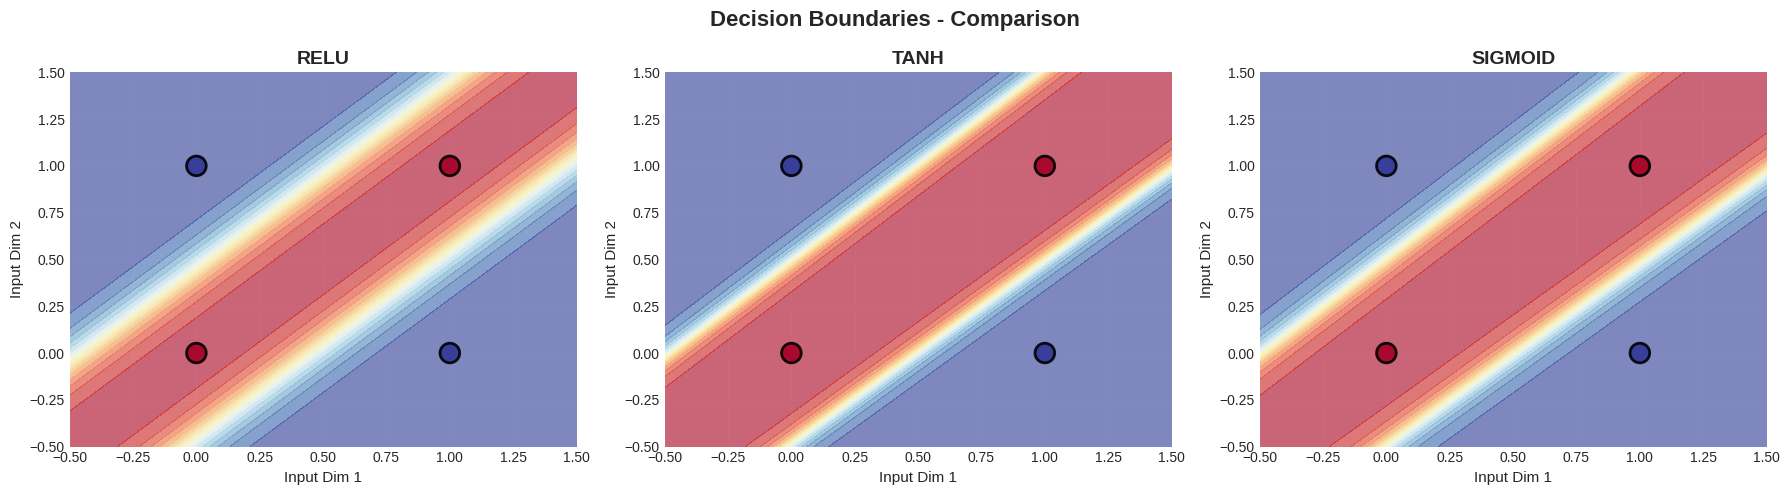

In [21]:
# Plot decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, activation in enumerate(activations):
    model = models[activation]
    model.eval()

    # Create mesh grid
    resolution = 100
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        predictions, _ = model(grid_points)
        predictions = torch.sigmoid(predictions).cpu().numpy()

    predictions = predictions.reshape(xx.shape)

    # Plot
    ax = axes[idx]
    contour = ax.contourf(xx, yy, predictions, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, predictions, levels=[0.5], colors='black', linewidths=2)

    # Data points
    x_np = x_data.cpu().numpy()
    y_np = y_data.cpu().numpy().ravel()
    ax.scatter(x_np[:, 0], x_np[:, 1], c=y_np,
               cmap='RdYlBu', s=200, edgecolors='black',
               linewidths=2, alpha=0.9)

    ax.set_title(f"{activation.upper()}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Input Dim 1", fontsize=11)
    ax.set_ylabel("Input Dim 2", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle("Decision Boundaries - Comparison", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualization: Training Loss Curves

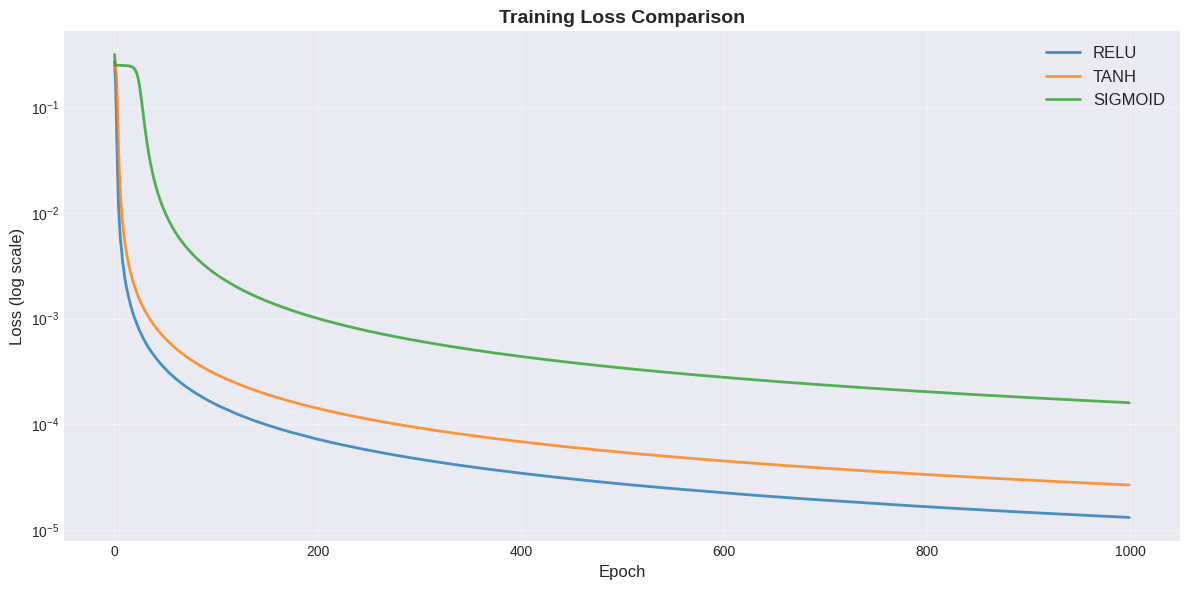

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

for activation in activations:
    epochs = range(len(histories[activation].losses))
    ax.plot(epochs, histories[activation].losses,
            linewidth=2, label=activation.upper(), alpha=0.8)

ax.set_yscale('log')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (log scale)", fontsize=12)
ax.set_title("Training Loss Comparison", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization: Weight Trajectories

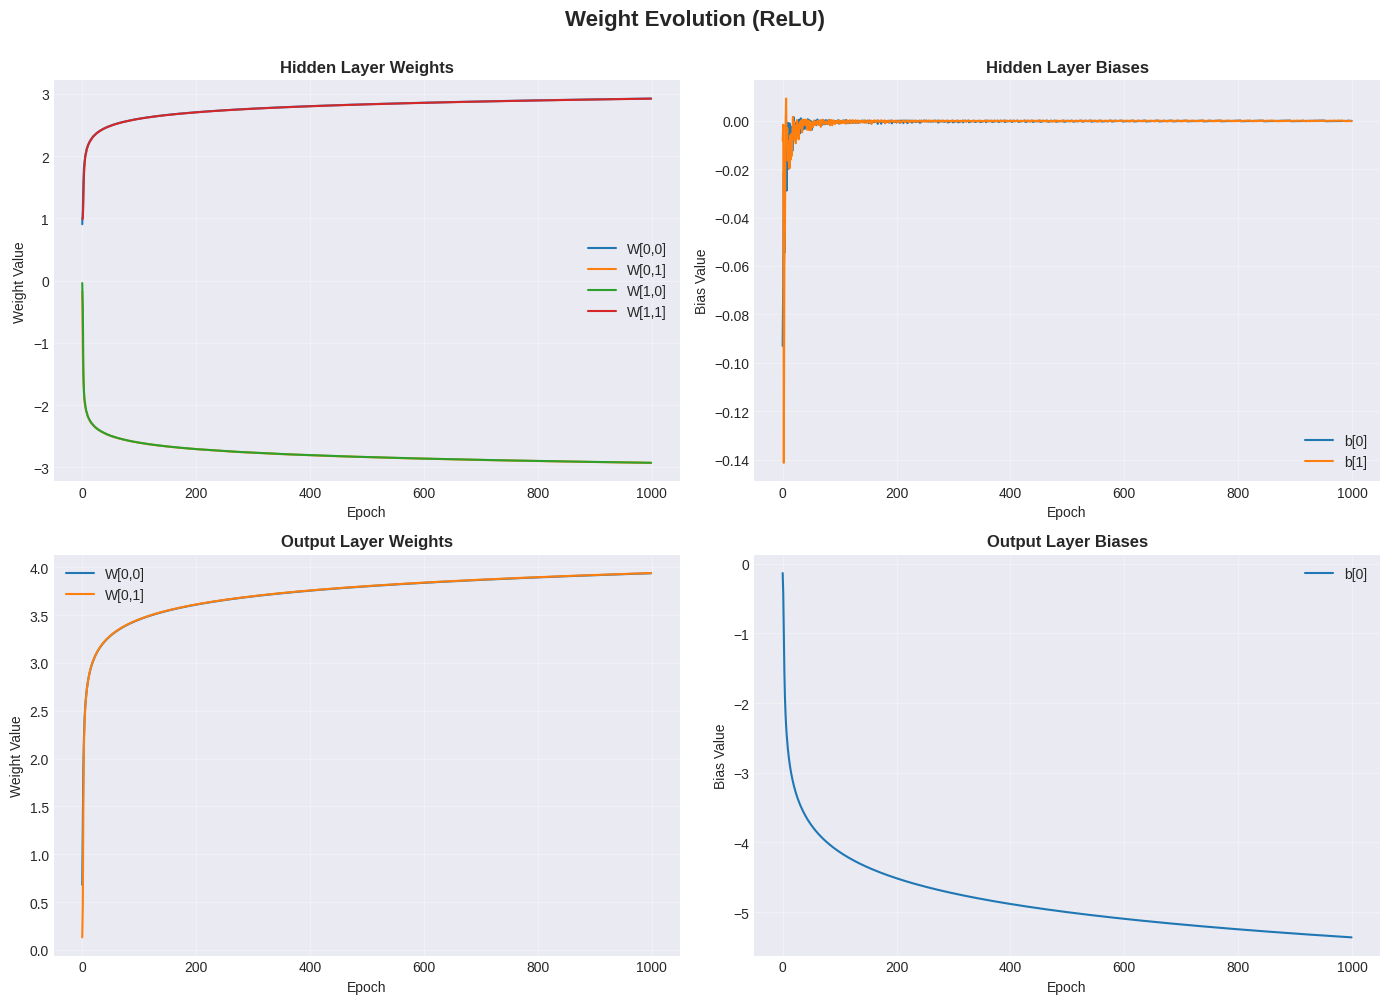

In [23]:
# Plot weight evolution for ReLU (most interesting)
fig = plot_weight_trajectories(histories['relu'],
                               title="Weight Evolution (ReLU)")
plt.show()

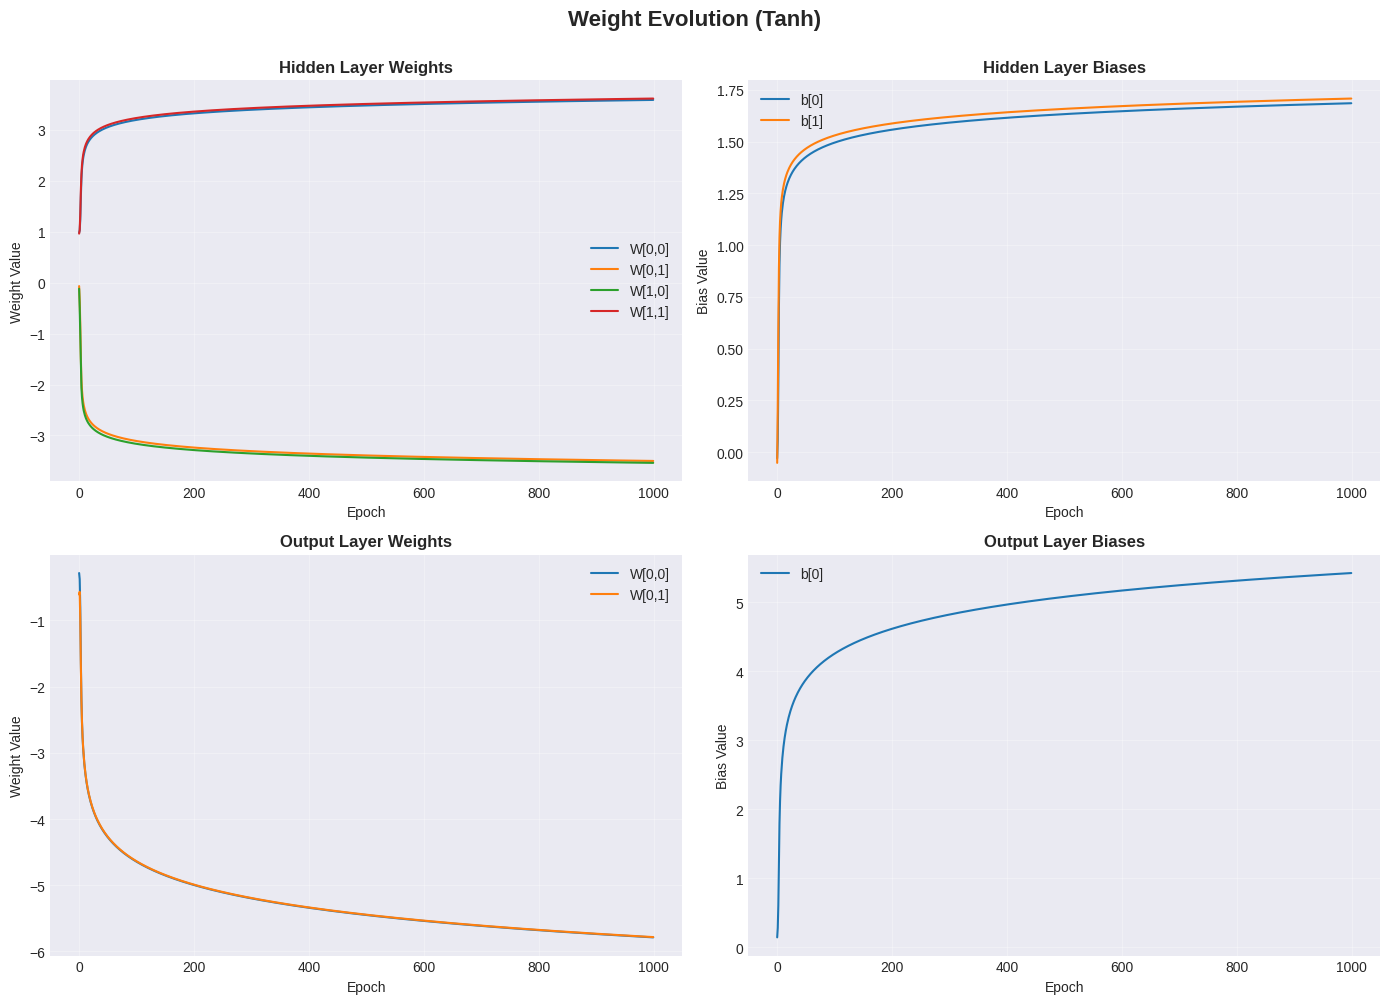

In [24]:
# Plot weight evolution for Tanh
fig = plot_weight_trajectories(histories['tanh'],
                               title="Weight Evolution (Tanh)")
plt.show()

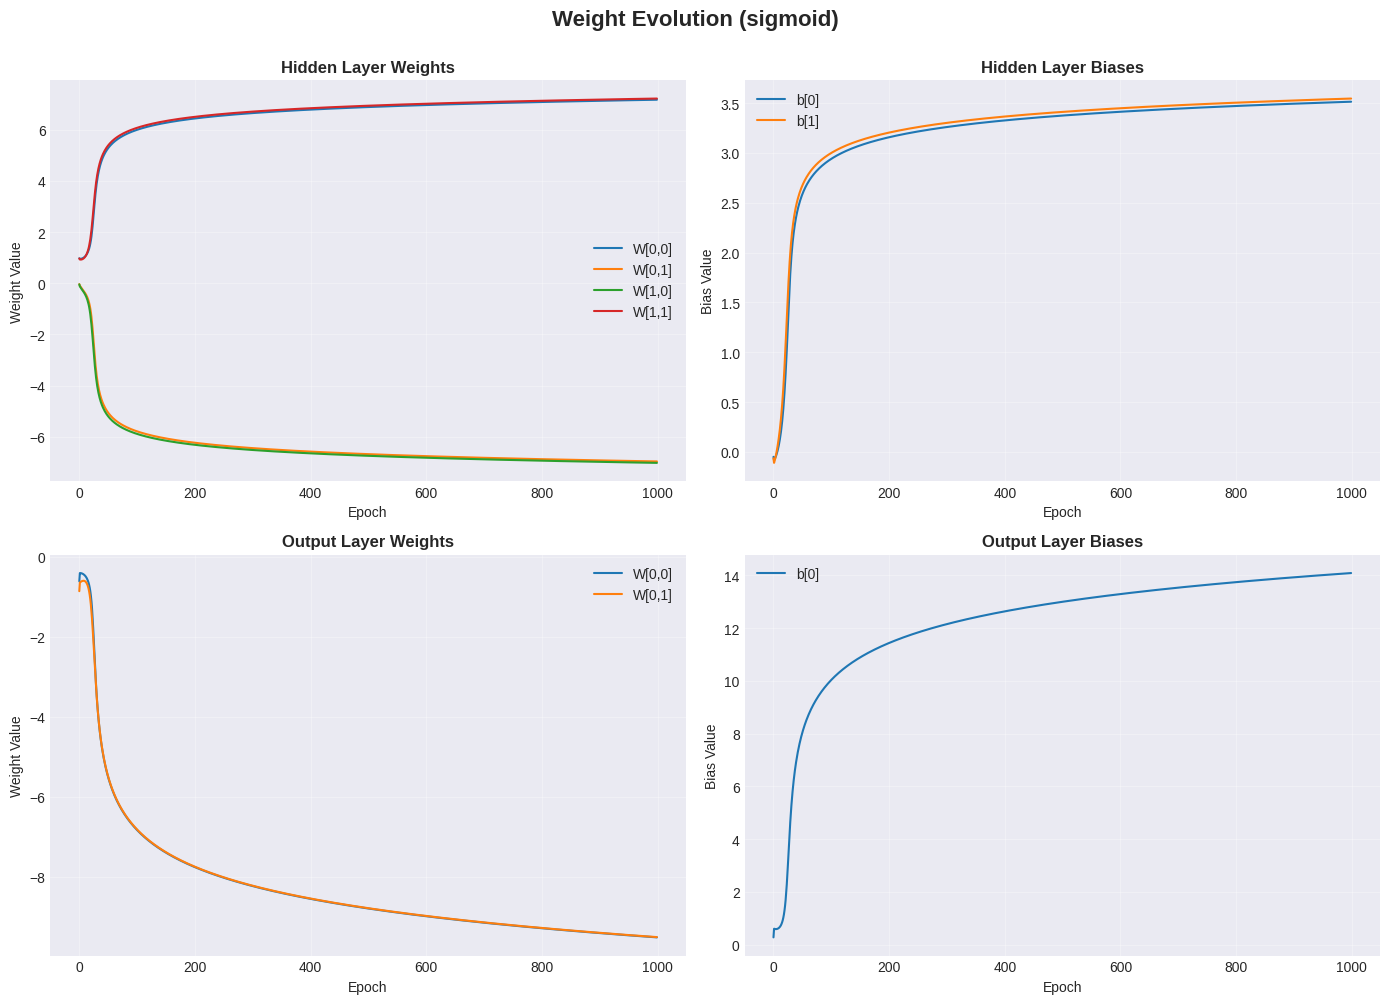

In [25]:
# Plot weight evolution for Sigmoid
fig = plot_weight_trajectories(histories['sigmoid'],
                               title="Weight Evolution (sigmoid)")
plt.show()

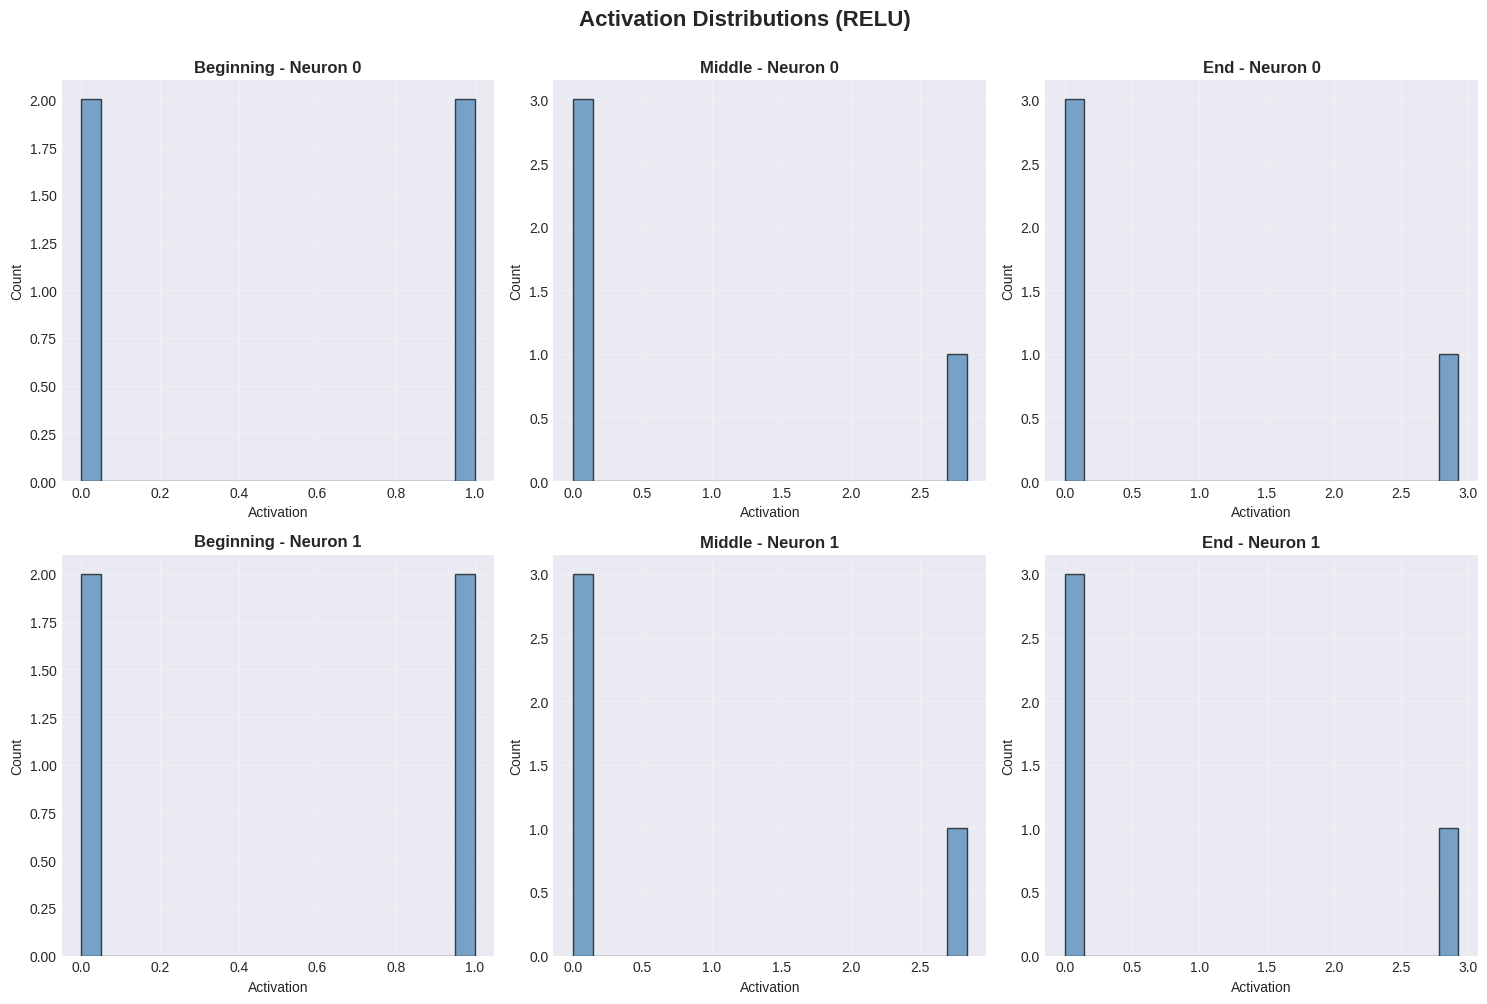

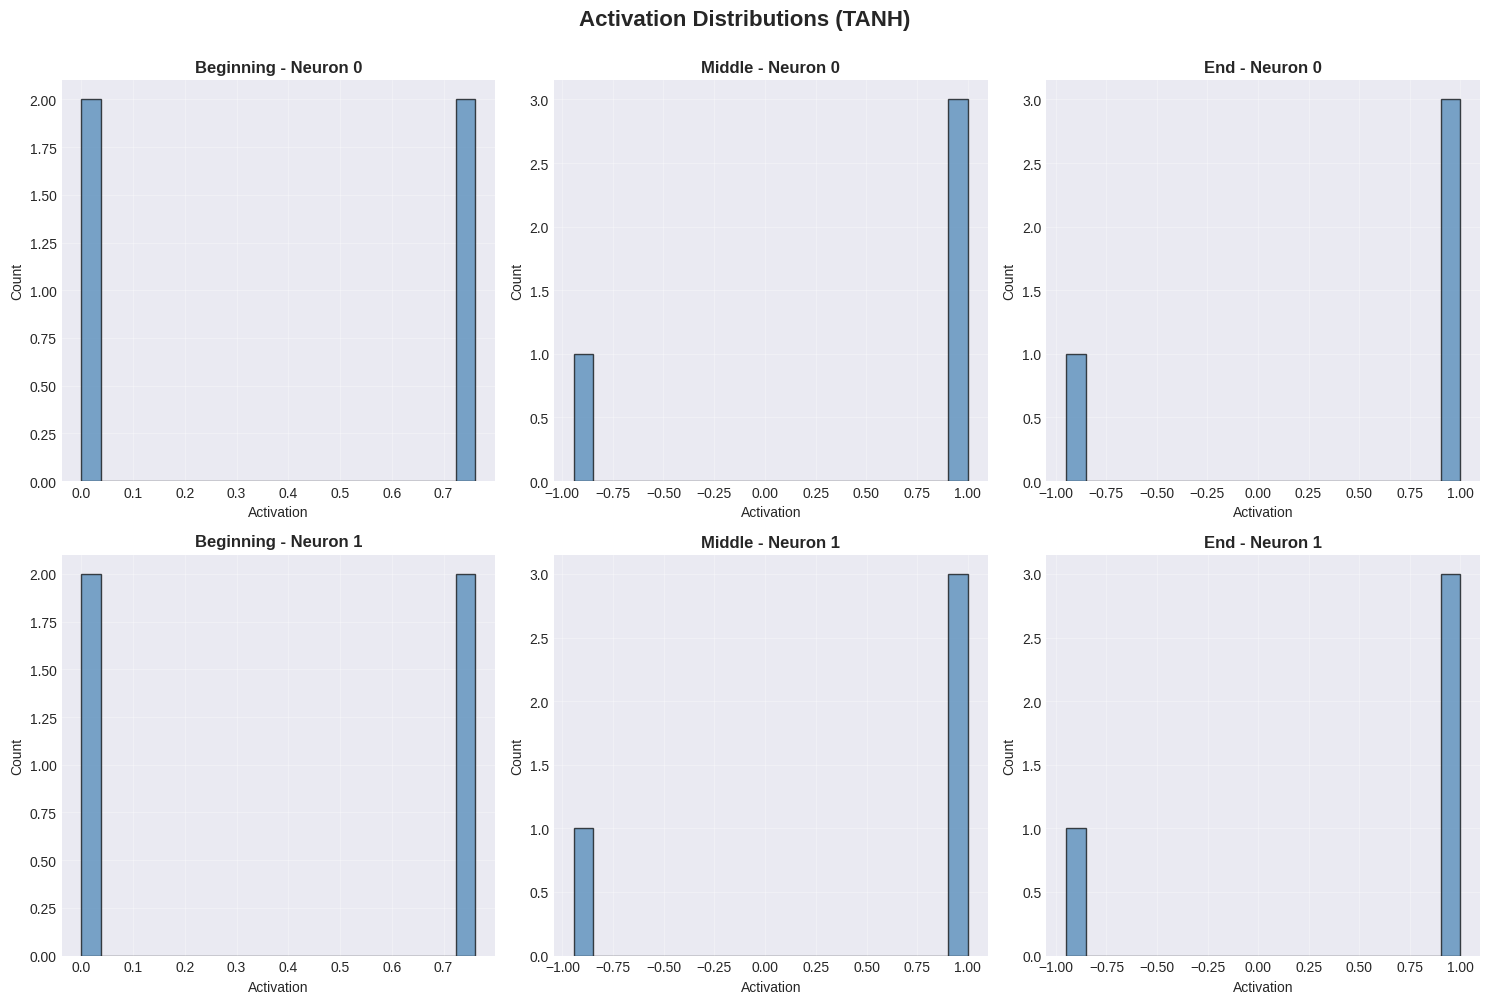

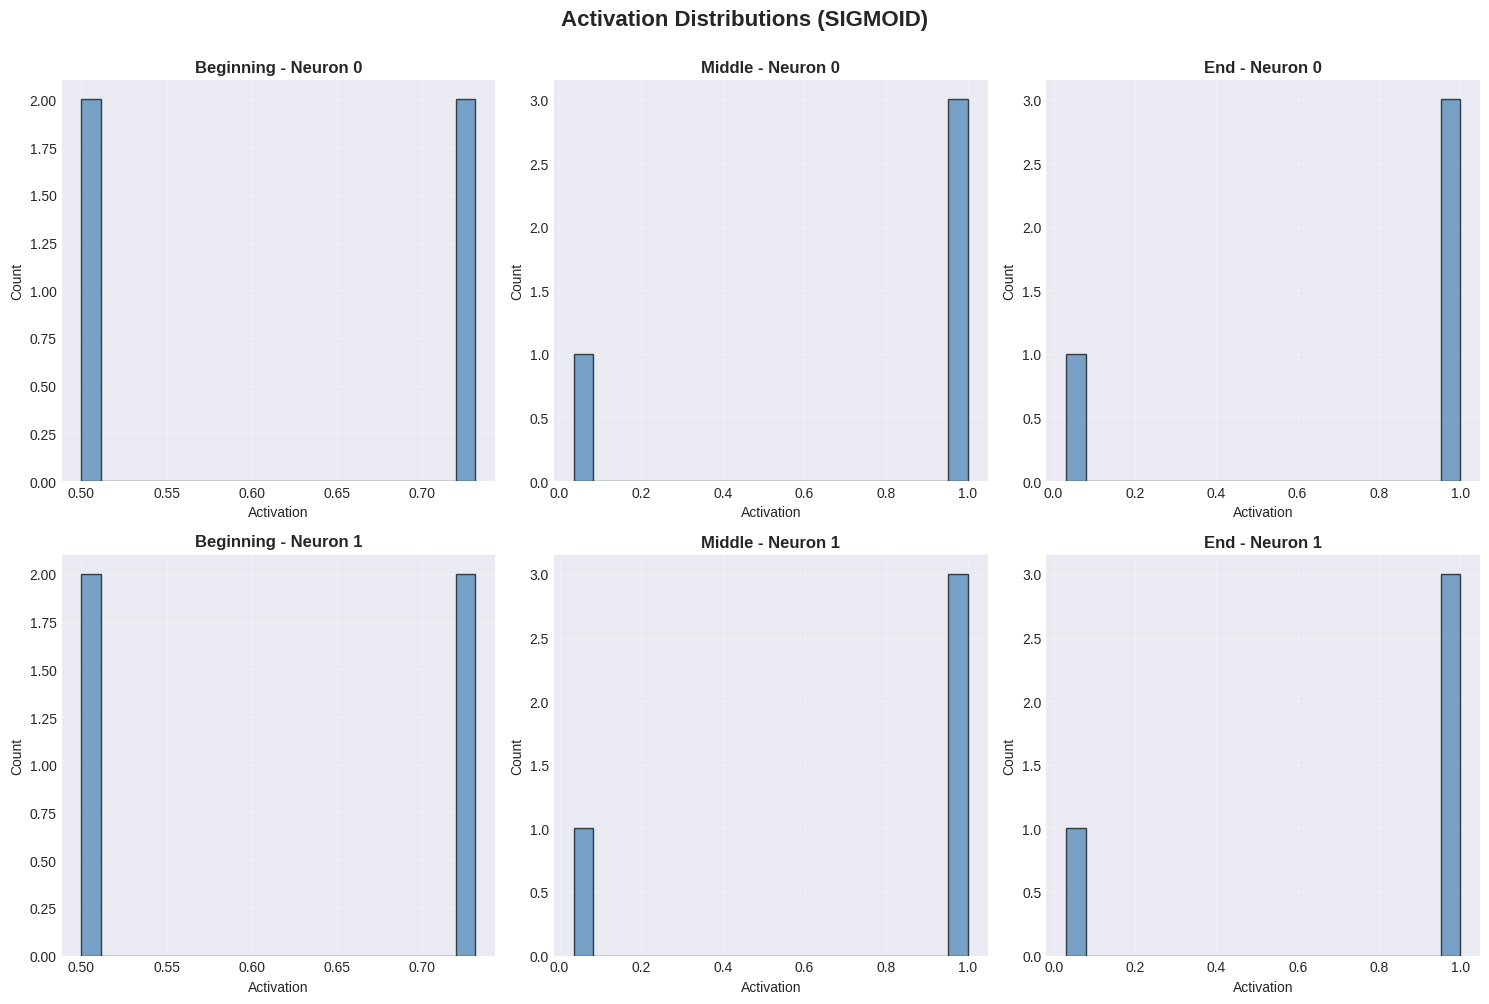

In [26]:
# Compare activation patterns
for activation in activations:
    latent_history = histories[activation].get_latent_tensor()
    fig = plot_activation_histograms(latent_history,
                                     title=f"Activation Distributions ({activation.upper()})")
    plt.show()

## Experiment 2: Noise Robustness

Test how adding noise to inputs or labels affects the learned representations.

In [40]:
console.print("\n[bold cyan]Experiment 2: Noise Robustness[/bold cyan]")

noise_levels = [0.0, 0.05, 0.1, 0.2]
noise_histories = {}

for noise in noise_levels:
    console.print(f"\n[bold]Training with noise level: {noise}[/bold]")

    # Generate noisy data
    x_noisy, y_noisy = generate_xor(noise=noise)

    # Train model
    model = TwoLayerNet(input_dim=2, hidden_dim=2, output_dim=1, activation='tanh')
    history = train_model(
        model=model,
        x_data=x_noisy,
        y_data=y_noisy,
        lr=3,
        max_epochs=10000,
        threshold=1e-5,
        device=device,
        record_interval=10,
        use_bce=False
    )

    noise_histories[noise] = {
        'history': history,
        'model': model,
        'x_data': x_noisy,
        'y_data': y_noisy
    }

Experiment 2: Noise Robustness

Training with noise level: 0.0

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.255073, Accuracy 0.7500

Epoch 1000: Loss 0.000351, Accuracy 1.0000

Epoch 2000: Loss 0.000154, Accuracy 1.0000

Epoch 3000: Loss 0.000098, Accuracy 1.0000

Epoch 4000: Loss 0.000072, Accuracy 1.0000

Epoch 5000: Loss 0.000056, Accuracy 1.0000

Epoch 6000: Loss 0.000047, Accuracy 1.0000

Epoch 7000: Loss 0.000040, Accuracy 1.0000

Epoch 8000: Loss 0.000034, Accuracy 1.0000

Epoch 9000: Loss 0.000030, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000027

Training with noise level: 0.05

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.255911, Accuracy 0.5000

Epoch 1000: Loss 0.000312, Accuracy 1.0000

Epoch 2000: Loss 0.000145, Accuracy 1.0000

Epoch 3000: Loss 0.000094, Accuracy 1.0000

Epoch 4000: Loss 0.000070, Accuracy 1.0000

Epoch 5000: Loss 0.000055, Accuracy 1.0000

Epoch 6000: Loss 0.000046, Accuracy 1.0000

Epoch 7000: Loss 0.000039, Accuracy 1.0000

Epoch 8000: Loss 0.000034, Accuracy 1.0000

Epoch 9000: Loss 0.000030, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000027

Training with noise level: 0.1

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.248499, Accuracy 0.5000

Epoch 1000: Loss 0.125321, Accuracy 0.5000

Epoch 2000: Loss 0.125151, Accuracy 0.5000

Epoch 3000: Loss 0.125098, Accuracy 0.5000

Epoch 4000: Loss 0.125071, Accuracy 0.5000

Epoch 5000: Loss 0.125056, Accuracy 0.5000

Epoch 6000: Loss 0.125045, Accuracy 0.5000

Epoch 7000: Loss 0.125038, Accuracy 0.5000

Epoch 8000: Loss 0.125032, Accuracy 0.5000

Epoch 9000: Loss 0.125028, Accuracy 0.5000

Training finished after 10000 epochs

Final loss: 0.125024

Training with noise level: 0.2

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.233076, Accuracy 0.5000

Epoch 1000: Loss 0.000540, Accuracy 1.0000

Epoch 2000: Loss 0.000168, Accuracy 1.0000

Epoch 3000: Loss 0.000100, Accuracy 1.0000

Epoch 4000: Loss 0.000071, Accuracy 1.0000

Epoch 5000: Loss 0.000055, Accuracy 1.0000

Epoch 6000: Loss 0.000045, Accuracy 1.0000

Epoch 7000: Loss 0.000038, Accuracy 1.0000

Epoch 8000: Loss 0.000033, Accuracy 1.0000

Epoch 9000: Loss 0.000029, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000026

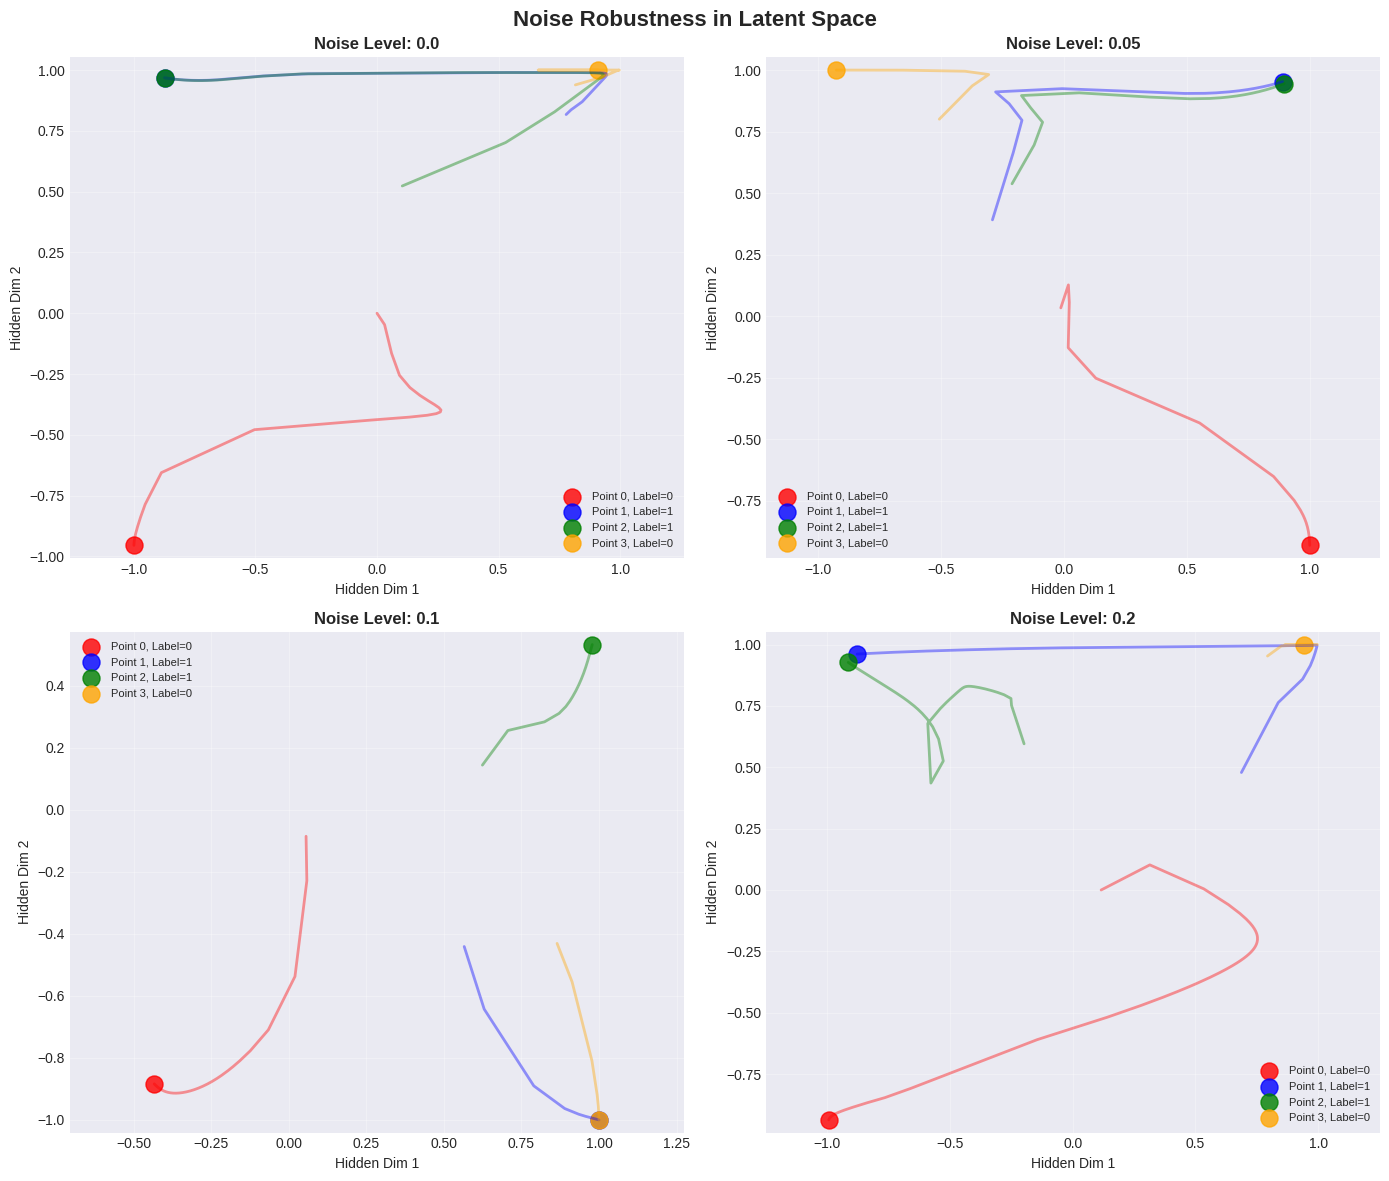

In [41]:
# Visualize noise robustness
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, noise in enumerate(noise_levels):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    data = noise_histories[noise]
    latent_history = data['history'].get_latent_tensor()
    x_noisy = data['x_data']
    y_noisy = data['y_data']

    colors = ["red", "blue", "green", "orange"]
    n_samples = latent_history.shape[1]

    for i in range(n_samples):
        coords = latent_history[:, i, :]
        label_val = int(y_noisy[i].item())

        ax.plot(coords[:, 0], coords[:, 1], color=colors[i],
                alpha=0.4, linewidth=2)
        ax.scatter(coords[-1, 0], coords[-1, 1], color=colors[i],
                   alpha=0.8, marker='o', s=150,
                   label=f"Point {i}, Label={label_val}")

    ax.set_title(f"Noise Level: {noise}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Hidden Dim 1")
    ax.set_ylabel("Hidden Dim 2")
    ax.axis("equal")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Noise Robustness in Latent Space", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Experiment 3: 3-Input XOR with PCA Visualization

Explore higher-dimensional hidden representations using PCA.

Principal Component Analysis (PCA) is a linear dimensionality reduction method that transforms correlated variables into uncorrelated *principal components* capturing maximal variance. Given a zero-mean dataset $X \in \mathbb{R}^{n \times p}$, PCA finds orthogonal directions $w_i$ solving
$$\Sigma w_i = \lambda_i w_i, \quad \text{where } \Sigma = \tfrac{1}{n} X^\top X$$
The eigenvectors $w_i$ define orthogonal axes ordered by decreasing eigenvalues $\lambda_i$, representing explained variance. Equivalently, PCA provides the best rank-$k$ approximation $X \approx U_k S_k V_k^\top$ from the SVD (Singular Value Decomposition) of $X$, retaining maximal information in $k$ dimensions.

In [42]:
console.print("\n[bold cyan]Experiment 3: 3-Input XOR[/bold cyan]")

# Generate 3-input XOR
x_data_3d, y_data_3d = generate_3input_xor()
console.print(f"3-Input XOR Dataset shape: {x_data_3d.shape}")

# Train with larger hidden layer
model_3d = TwoLayerNet(input_dim=3, hidden_dim=4, output_dim=1, activation='tanh')
history_3d = train_model(
    model=model_3d,
    x_data=x_data_3d,
    y_data=y_data_3d,
    lr=3,
    max_epochs=10000,
    threshold=1e-5,
    device=device,
    record_interval=10,
    use_bce=False
)

Experiment 3: 3-Input XOR

3-Input XOR Dataset shape: torch.Size([8, 3])

Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.257816, Accuracy 0.5000

Epoch 1000: Loss 0.000256, Accuracy 1.0000

Epoch 2000: Loss 0.000121, Accuracy 1.0000

Epoch 3000: Loss 0.000078, Accuracy 1.0000

Epoch 4000: Loss 0.000058, Accuracy 1.0000

Epoch 5000: Loss 0.000046, Accuracy 1.0000

Epoch 6000: Loss 0.000038, Accuracy 1.0000

Epoch 7000: Loss 0.000032, Accuracy 1.0000

Epoch 8000: Loss 0.000028, Accuracy 1.0000

Epoch 9000: Loss 0.000025, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000022

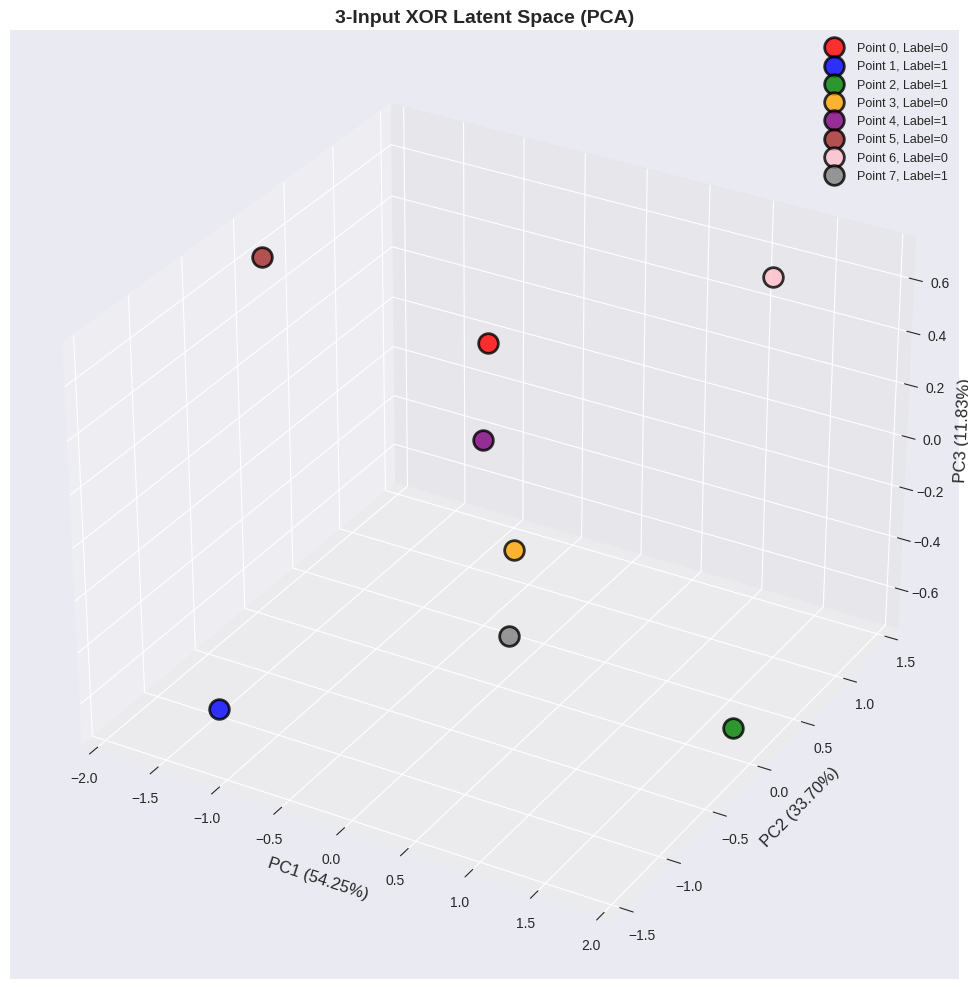

In [43]:
# Visualize with PCA
latent_history_3d = history_3d.get_latent_tensor()
fig = plot_3d_latent_pca(latent_history_3d, y_data_3d,
                         title="3-Input XOR Latent Space (PCA)")
plt.show()

## Experiment 4: Complex Datasets

Test on more complex datasets: Two Moons, Spirals and circles.

We implement the `generate_spiral` dataset. This is a historic benchmark in neural network literature introduced by [Lang, K. J., & Witbrock, M. J. (1988)](https://www.researchgate.net/publication/269337640_Learning_to_Tell_Two_Spirals_Apart).

The "Two Spirals" problem was historically considered extremely difficult for standard backpropagation to solve. Therefore, solving the spiral dataset with a standard MLP is a significant test of representation learning capabilities.

In [44]:
console.print("\n[bold cyan]Experiment 4: Complex Datasets[/bold cyan]")

datasets = {
    'Two Moons': generate_two_moons(n_samples=1000, noise=0.1),
    'Spiral': generate_spiral(n_samples=1000, noise=0.2),
    'Circles': generate_circles(n_samples=1000, noise=0.1)
}

complex_results = {}

for name, (x_data_complex, y_data_complex) in datasets.items():
    console.print(f"\n[bold]Training on {name}[/bold]")

    model_complex = TwoLayerNet(input_dim=2, hidden_dim=8, output_dim=1, activation='relu')
    history_complex = train_model(
        model=model_complex,
        x_data=x_data_complex,
        y_data=y_data_complex,
        lr=3,
        max_epochs=5000,
        threshold=1e-5,
        device=device,
        record_interval=50,
        use_bce=True
    )

    complex_results[name] = {
        'model': model_complex,
        'history': history_complex,
        'x_data': x_data_complex,
        'y_data': y_data_complex
    }

Experiment 4: Complex Datasets

Training on Two Moons

Using BCEWithLogitsLoss as loss function.

Training on cuda...

Output()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:134: UserWarning: Deterministic behavior was 
enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, 
but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic 
behavior in this case, you must set an environment variable before running your PyTorch application: 
CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to 
https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at 
/pytorch/aten/src/ATen/Context.cpp:315.)
  return F.linear(input, self.weight, self.bias)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was 
enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, 
but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic 
behavior in this case, you must set an environment variable before running your PyTorch application: 
CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to 
https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at 
/pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

Epoch 0: Loss 0.765016, Accuracy 0.4290

Epoch 1000: Loss 0.002528, Accuracy 1.0000

Epoch 2000: Loss 0.001329, Accuracy 1.0000

Epoch 3000: Loss 0.000904, Accuracy 1.0000

Epoch 4000: Loss 0.000689, Accuracy 1.0000

Training finished after 5000 epochs

Final loss: 0.000557

Training on Spiral

Using BCEWithLogitsLoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.790536, Accuracy 0.3660

Epoch 1000: Loss 0.005133, Accuracy 0.9995

Epoch 2000: Loss 0.002051, Accuracy 1.0000

Epoch 3000: Loss 0.001215, Accuracy 1.0000

Epoch 4000: Loss 0.000833, Accuracy 1.0000

Training finished after 5000 epochs

Final loss: 0.000626

Training on Circles

Using BCEWithLogitsLoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.677091, Accuracy 0.5050

Epoch 1000: Loss 0.015650, Accuracy 0.9970

Epoch 2000: Loss 0.011912, Accuracy 0.9970

Epoch 3000: Loss 0.010293, Accuracy 0.9970

Epoch 4000: Loss 0.009325, Accuracy 0.9970

Training finished after 5000 epochs

Final loss: 0.008652

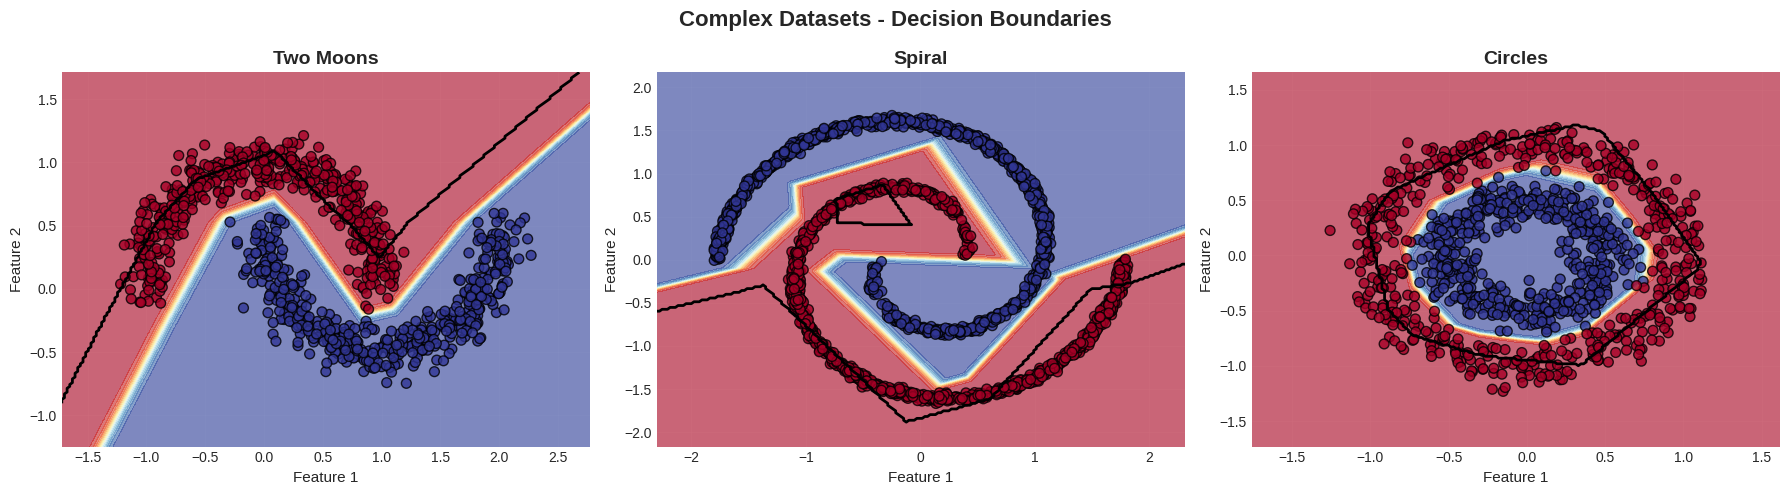

In [45]:
# Visualize complex datasets - Decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(complex_results.items()):
    model = data['model']
    x_data_complex = data['x_data']
    y_data_complex = data['y_data']

    model.eval()

    # Create mesh
    resolution = 200
    x_min, x_max = x_data_complex[:, 0].min() - 0.5, x_data_complex[:, 0].max() + 0.5
    y_min, y_max = x_data_complex[:, 1].min() - 0.5, x_data_complex[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Predict
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        predictions, _ = model(grid_points)
        predictions = torch.sigmoid(predictions).cpu().numpy()

    predictions = predictions.reshape(xx.shape)

    # Plot
    ax = axes[idx]
    contour = ax.contourf(xx, yy, predictions, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, predictions, levels=[0.5], colors='black', linewidths=2)

    # Data points
    x_np = x_data_complex.cpu().numpy()
    y_np = y_data_complex.cpu().numpy().ravel()
    ax.scatter(x_np[:, 0], x_np[:, 1], c=y_np,
               cmap='RdYlBu', s=50, edgecolors='black',
               linewidths=1, alpha=0.8)

    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel("Feature 1", fontsize=11)
    ax.set_ylabel("Feature 2", fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle("Complex Datasets - Decision Boundaries", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

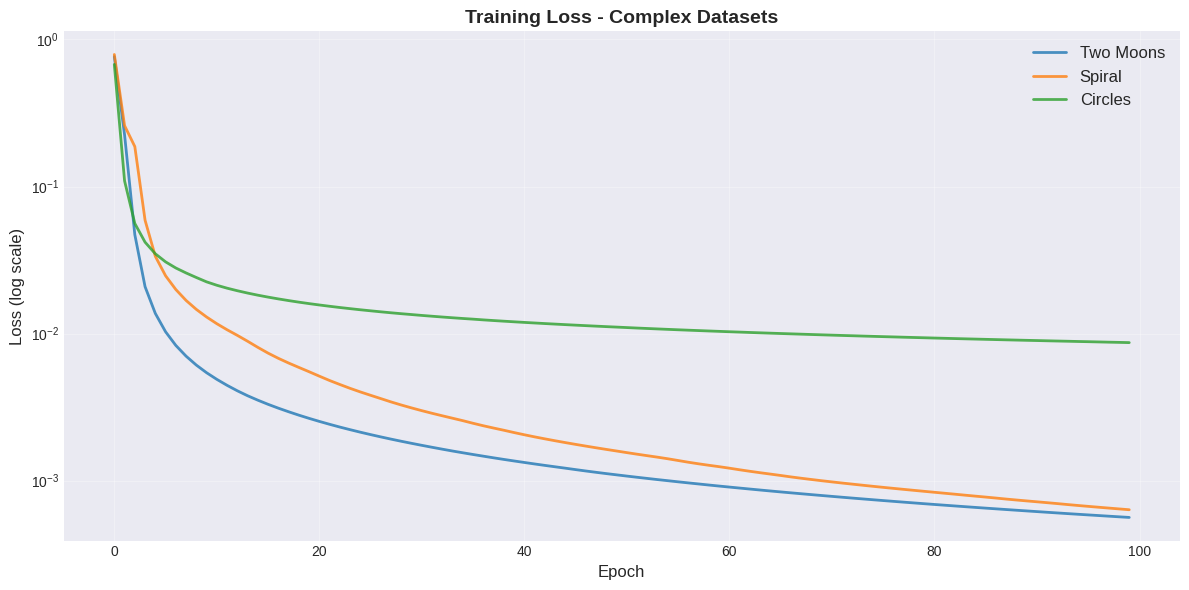

In [46]:
# Loss curves for complex datasets
fig, ax = plt.subplots(figsize=(12, 6))

for name, data in complex_results.items():
    epochs = range(len(data['history'].losses))
    ax.plot(epochs, data['history'].losses,
            linewidth=2, label=name, alpha=0.8)

ax.set_yscale('log')
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (log scale)", fontsize=12)
ax.set_title("Training Loss - Complex Datasets", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment 5: Loss Landscape Visualization

Visualize the loss landscape around the final solution.

[Li et al., 2018](https://arxiv.org/abs/1712.09913) describes the methodology for visualizing high-dimensional loss functions in 2D or 3D plots (using contour plots and surface maps), exactly as implemented in our `compute_loss_landscape` function.

Experiment 5: Loss Landscape

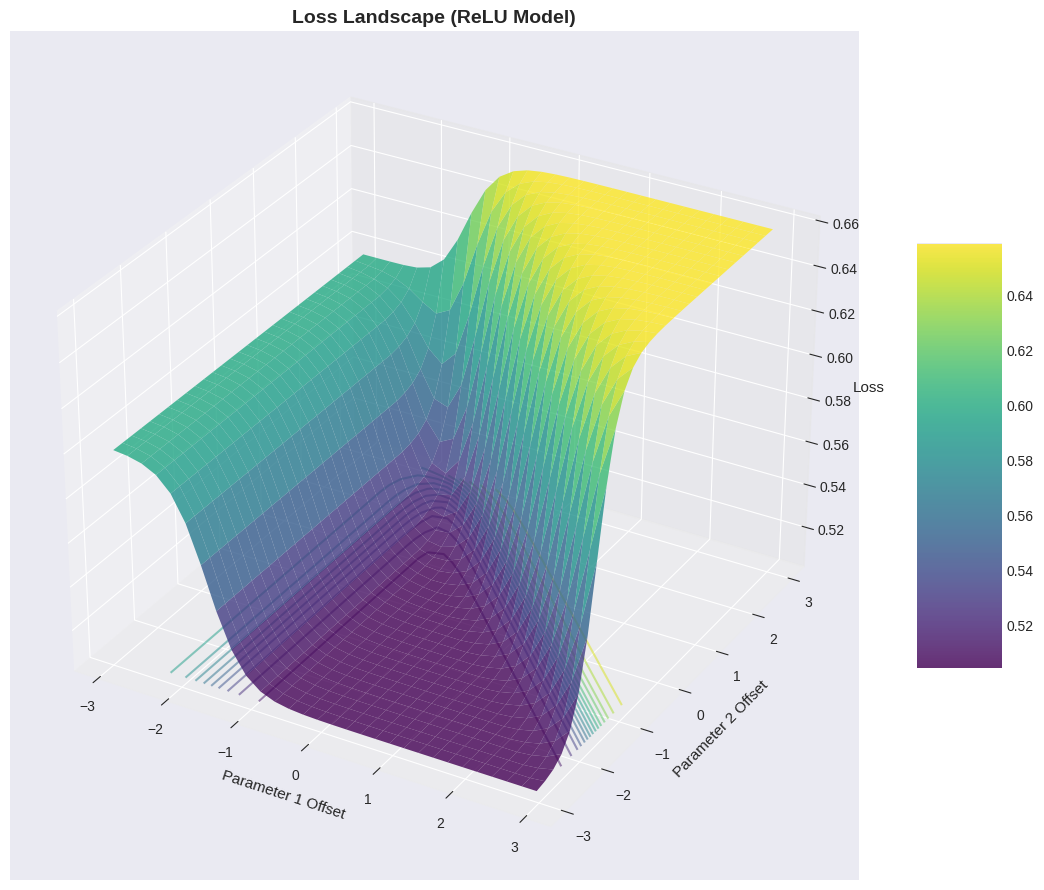

In [47]:
console.print("\n[bold cyan]Experiment 5: Loss Landscape[/bold cyan]")


def compute_loss_landscape(model, x_data, y_data, param_idx=0,
                           range_scale=2.0, resolution=50):
    """Compute 2D loss landscape around current parameters."""
    import torch.nn as nn

    # Get current parameters
    params = list(model.parameters())
    if param_idx >= len(params):
        param_idx = 0

    current_param = params[param_idx].data.clone()

    # Create grid
    param_range = current_param.abs().mean().cpu().item() * range_scale
    if current_param.numel() >= 2:
        x_range = np.linspace(-param_range, param_range, resolution)
        y_range = np.linspace(-param_range, param_range, resolution)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.zeros_like(X)
        criterion = nn.BCEWithLogitsLoss()

        # Compute loss for each point
        for i in range(resolution):
            for j in range(resolution):
                # Modify parameters
                params[param_idx].data = current_param.clone()
                if current_param.numel() >= 2:
                    params[param_idx].data.view(-1)[0] += X[i, j]
                    params[param_idx].data.view(-1)[1] += Y[i, j]

                # Compute loss
                with torch.no_grad():
                    output, _ = model(x_data.to(device))
                    loss = criterion(output, y_data.to(device))
                    Z[i, j] = loss.item()

        # Restore parameters
        params[param_idx].data = current_param

        return X, Y, Z

    return None, None, None


# Compute landscape for ReLU model
model_relu = models['relu']
X, Y, Z = compute_loss_landscape(model_relu, x_data, y_data,
                                 param_idx=0, range_scale=1.0, resolution=30)

if X is not None:
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.contour(X, Y, Z, levels=15, cmap='viridis', linestyles='solid',
               offset=Z.min(), alpha=0.5)

    ax.set_xlabel('Parameter 1 Offset', fontsize=11)
    ax.set_ylabel('Parameter 2 Offset', fontsize=11)
    ax.set_zlabel('Loss', fontsize=11)
    ax.set_title('Loss Landscape (ReLU Model)', fontsize=14, fontweight='bold')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

## Experiment 6: Mode Connectivity & Parameter Symmetry

Running Experiment 6: Mode Connectivity...

Training Model A...


Using MSELoss as loss function.

Training on cuda...

Output()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:134: UserWarning: Deterministic behavior was 
enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, 
but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic 
behavior in this case, you must set an environment variable before running your PyTorch application: 
CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to 
https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at 
/pytorch/aten/src/ATen/Context.cpp:315.)
  return F.linear(input, self.weight, self.bias)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was 
enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, 
but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic 
behavior in this case, you must set an environment variable before running your PyTorch application: 
CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to 
https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at 
/pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

Epoch 0: Loss 0.256529, Accuracy 0.7500

Epoch 1000: Loss 0.000161, Accuracy 1.0000

Epoch 2000: Loss 0.000073, Accuracy 1.0000

Epoch 3000: Loss 0.000046, Accuracy 1.0000

Epoch 4000: Loss 0.000033, Accuracy 1.0000

Epoch 5000: Loss 0.000026, Accuracy 1.0000

Epoch 6000: Loss 0.000021, Accuracy 1.0000

Epoch 7000: Loss 0.000018, Accuracy 1.0000

Epoch 8000: Loss 0.000016, Accuracy 1.0000

Epoch 9000: Loss 0.000014, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000012

Training Model B...


Using MSELoss as loss function.

Training on cuda...

Output()

Epoch 0: Loss 0.253612, Accuracy 0.7500

Epoch 1000: Loss 0.000151, Accuracy 1.0000

Epoch 2000: Loss 0.000067, Accuracy 1.0000

Epoch 3000: Loss 0.000042, Accuracy 1.0000

Epoch 4000: Loss 0.000031, Accuracy 1.0000

Epoch 5000: Loss 0.000024, Accuracy 1.0000

Epoch 6000: Loss 0.000019, Accuracy 1.0000

Epoch 7000: Loss 0.000016, Accuracy 1.0000

Epoch 8000: Loss 0.000014, Accuracy 1.0000

Epoch 9000: Loss 0.000012, Accuracy 1.0000

Training finished after 10000 epochs

Final loss: 0.000011

Computing loss along linear path...


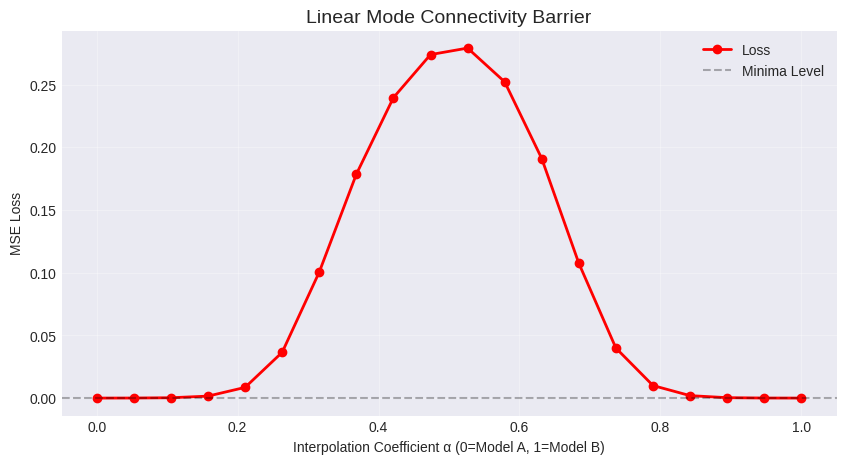

✓ Experiment 6 completed!

In [55]:
console.print("\n[bold blue]Running Experiment 6: Mode Connectivity...[/bold blue]")

def get_flat_params(model):
    """Estrae tutti i parametri del modello in un singolo vettore 1D."""
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    return torch.cat(params)

def set_flat_params(model, flat_params):
    """Imposta i parametri del modello da un vettore 1D."""
    offset = 0
    for param in model.parameters():
        numel = param.numel()
        param.data = flat_params[offset:offset+numel].view(param.shape)
        offset += numel

# 1. Training of two identical indipendent models
print("Training Model A...")
model_a = TwoLayerNet(input_dim=2, hidden_dim=10, output_dim=1, activation="tanh") # Hidden size più grande aiuta
_ = train_model(model_a, x_data, y_data, lr=3, max_epochs=10000, device=device, use_bce=False)

print("Training Model B...")
model_b = TwoLayerNet(input_dim=2, hidden_dim=10, output_dim=1, activation="tanh")
_ = train_model(model_b, x_data, y_data, lr=3, max_epochs=10000, device=device, use_bce=False)

# 2. Linear interpolation between parameters
# θ(α) = (1 - α) * θ_A + α * θ_B
params_a = get_flat_params(model_a)
params_b = get_flat_params(model_b)

alphas = np.linspace(0, 1, 20)
losses = []
accuracies = []

# Temp model to evaluate the path
temp_model = TwoLayerNet(input_dim=2, hidden_dim=10, output_dim=1, activation="tanh")
temp_model.to(device)

print("Computing loss along linear path...")
criterion = torch.nn.MSELoss()

# Move x_data and y_data to the correct device
x_data_device = x_data.to(device)
y_data_device = y_data.to(device)

for alpha in alphas:
    # Calculate interpolated parameters
    interp_params = (1 - alpha) * params_a + alpha * params_b
    set_flat_params(temp_model, interp_params)

    # Evaluation
    with torch.no_grad():
        outputs_tuple = temp_model(x_data_device)
        outputs = outputs_tuple[0] # Get the actual output tensor
        loss = criterion(outputs, y_data_device).item()
        predicted = (outputs > 0.5).float()
        acc = (predicted == y_data_device).sum().item() / y_data_device.size(0)

    losses.append(loss)
    accuracies.append(acc)

# 3. Visualization
plt.figure(figsize=(10, 5))
plt.plot(alphas, losses, 'r-o', linewidth=2, label='Loss')
plt.axhline(y=min(losses), color='k', linestyle='--', alpha=0.3, label='Minima Level')
plt.title('Linear Mode Connectivity Barrier', fontsize=14)
plt.xlabel('Interpolation Coefficient α (0=Model A, 1=Model B)')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

console.print("[bold green]✓ Experiment 6 completed![/bold green]")

## Running more experiments
The file `CVIMR/CVIMR/run_experiments.py` contains a powerful and flexible implementation for running all possible experiments using `argparse`.

A few usage examples are shown below:

```
# XOR with ReLU
python -m CVIMR.run_experiments --dataset xor --activation relu --hidden 2

# Two Moons with Tanh
python -m CVIMR.run_experiments --dataset two_moons --activation tanh --hidden 8

# Spiral with different hidden sizes
python -m CVIMR.run_experiments --dataset spiral --activation relu --hidden 16
```


Feel free to experiment with it!